# Clustering to confirm the selection of 4 levels 

Load data

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [3]:

data = pd.read_csv('./extracted/preprocessed_data_full.csv')

Drop the labels, we are acting as if we do not know our labels

In [4]:
# function to get correlation matrix of features
def correlation_plot(dataframe, name):
   
   # Find the correlation matrix
   corr = dataframe.corr()
   
   # Create the mask for the upper triangle
   mask = np.triu(np.ones_like(corr, dtype=np.bool))
   
   # Set up the matplotlib figure
   f, ax = plt.subplots(figsize=(20, 20))
   
   # Generate a custom diverging colormap
   cmap = sns.diverging_palette(240, 10, as_cmap=True)
   sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})

   plt.title(f'Correlation of {name} Features')

C:\Users\ptut0\AppData\Local\Temp\ipykernel_5460\611317435.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


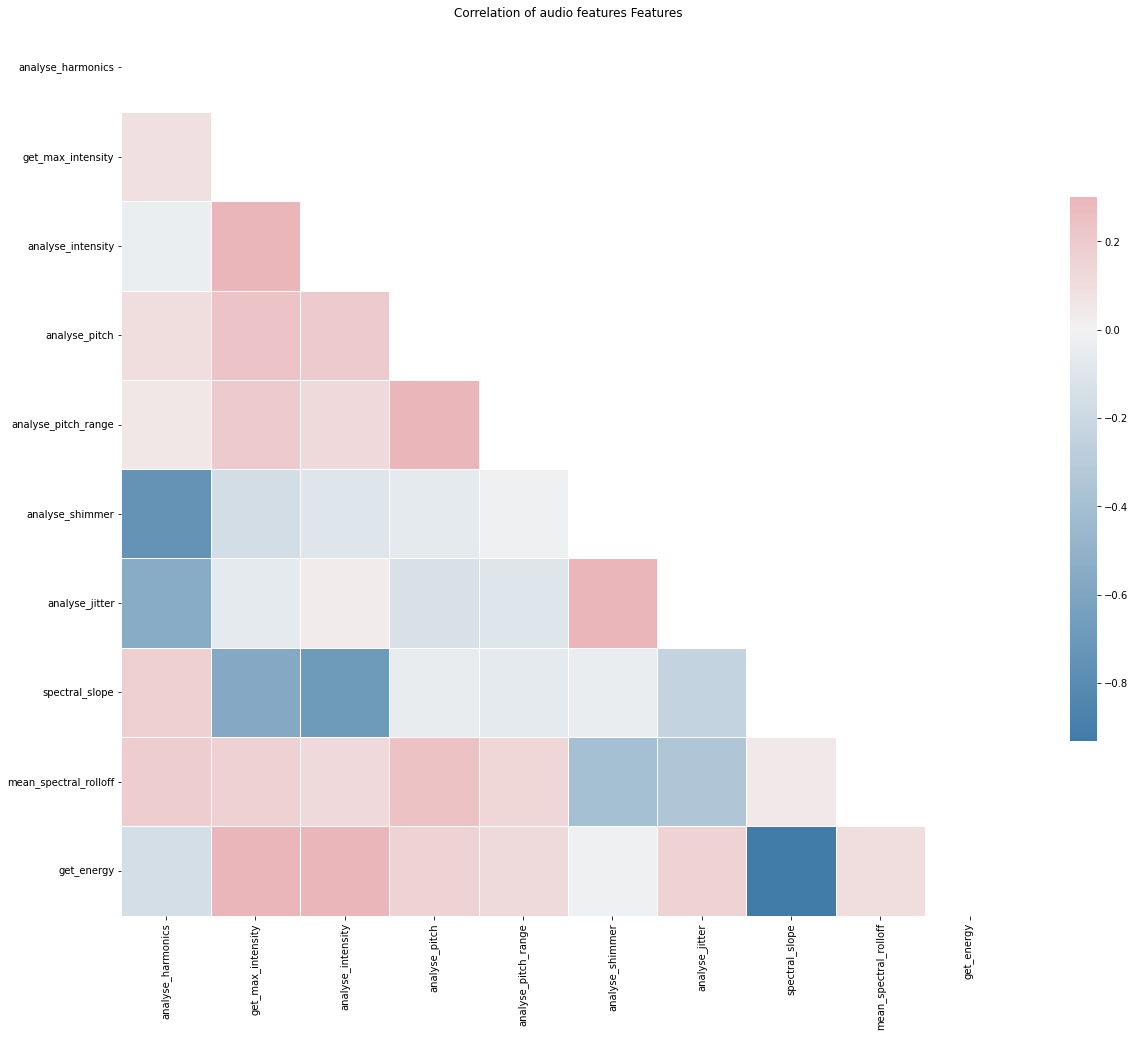

In [7]:
correlation_plot(data.drop(['parent_label', 'segment_label'], axis=1), "audio features")

There does not appear to be very clear groupings of correlations, we also saw significance in all of the features in the Anovas, so we will not attempt dimensionality reduction for modeling, however, we will to make our data verbalizable in 2 dimensions

Explained variation per principal component: [9.28030744e-01 4.90637476e-02 2.26521031e-02 1.97609826e-04
 4.78930828e-05]


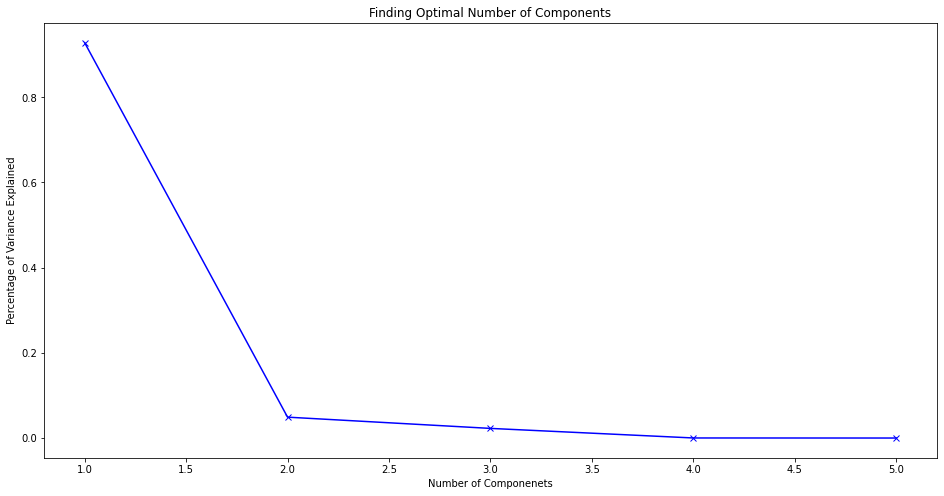

In [9]:
# Initialize PCA w/ n_components
pca = PCA(n_components=5)

# Fit the model & transform the features
principal_components = pca.fit_transform(data.drop(['parent_label', 'segment_label'], axis=1))

data["pca-one"] = principal_components[:,0]
data["pca-two"] = principal_components[:,1] 
data["pca-three"] = principal_components[:,2]

# How much of the variance in the dataset is explained? 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

plt.figure(figsize=(16,8))
num_components = [1,2,3,4,5]
plt.plot(num_components, pca.explained_variance_ratio_ , 'bx-')
plt.xlabel('Number of Componenets')
plt.ylabel('Percentage of Variance Explained')
plt.title('Finding Optimal Number of Components')
plt.show()

Two principal components to appear to cover the majority of the variance

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

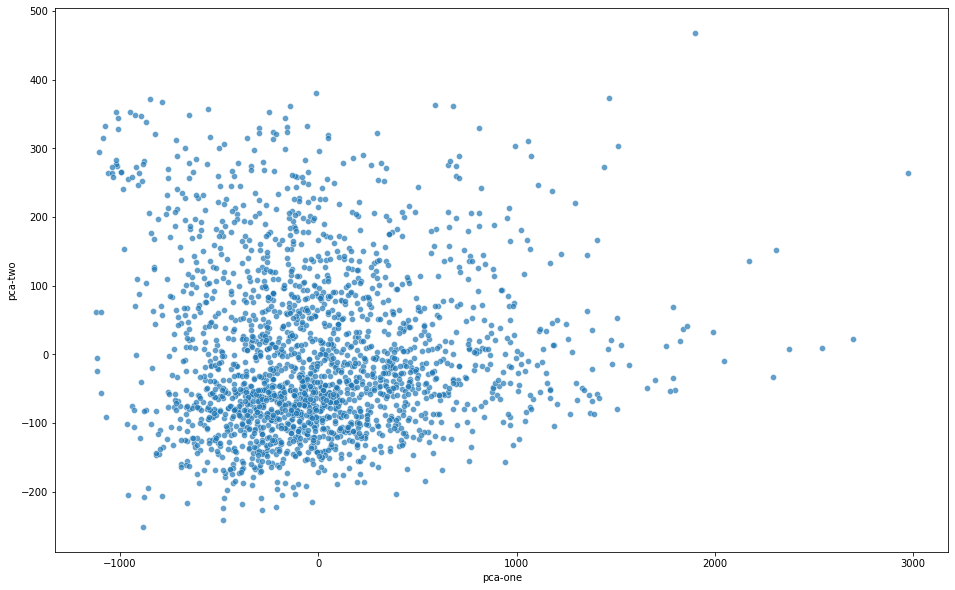

In [10]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    legend="full",
    data = data,
    alpha=0.7
)

Groupings don't appear particularity clear in any number, so lets try some modeling

See what number of cluster is suggested by K-means after PCA

In [12]:
# save first two PC as their own dataframe
pcs = {'pc1' : data["pca-one"], "pc2" : data["pca-two"]}
final_components = pd.DataFrame(pcs)

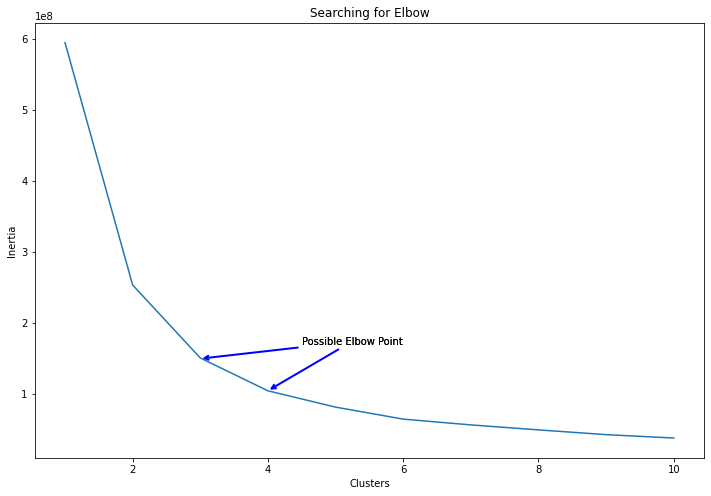

In [24]:
clusters = []

#collect inertia from 1-10 clusters
for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(final_components)
    cluster_labels = km.labels_
    clusters.append(km.inertia_)

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow of possible choices for K
ax.annotate('Possible Elbow Point', xy=(4, 105000000), xytext=(4.5, 170000000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))
ax.annotate('Possible Elbow Point', xy=(3, 150000000), xytext=(4.5, 170000000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

3 or 4 could be a good choice, so it does appear our choice of 4 groupings is plausible given the data

But let's double check for all components without PCA

In [33]:
# save first two PC as their own dataframe
features = pd.DataFrame(data.drop(['parent_label', 'segment_label', 'pca-one', 'pca-two'], axis=1))

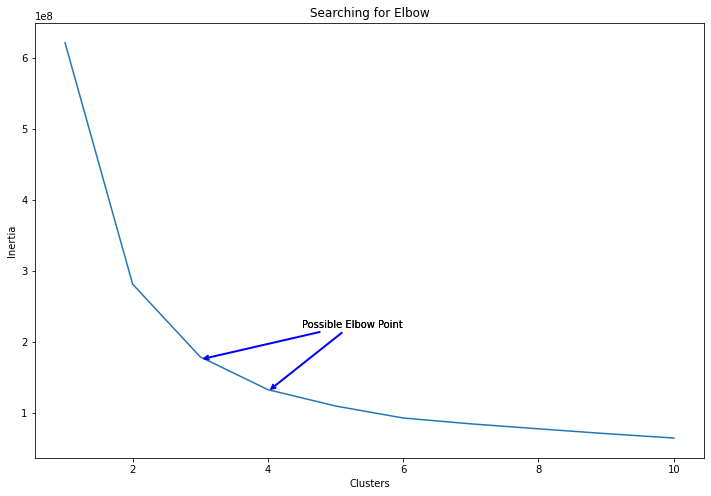

In [44]:
clusters = []

#collect inertia from 1-10 clusters
for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(features)
    cluster_labels = km.labels_
    clusters.append(km.inertia_)

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow of possible choices for K
ax.annotate('Possible Elbow Point', xy=(4, 130000000), xytext=(4.5, 220000000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))
ax.annotate('Possible Elbow Point', xy=(3, 175000000), xytext=(4.5, 220000000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

Still looks good!